In [101]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8

from scipy.stats import norm
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
import math
from datetime import date, datetime

In [102]:
data_train = pd.read_csv("KS_train_data.csv", delimiter=",")
data_train.set_index('project_id', inplace=True)
data_test = pd.read_csv("KS_test_data.csv", delimiter=";")
data_test.set_index('project_id', inplace=True)
list(data_train.head(0))

['backers_count',
 'blurb',
 'category',
 'converted_pledged_amount',
 'country',
 'created_at',
 'currency',
 'deadline',
 'fx_rate',
 'goal',
 'launched_at',
 'name',
 'pledged',
 'staff_pick',
 'usd_pledged',
 'location',
 'funded',
 'subcategory',
 'project_url',
 'reward_url']

    backers_count: numbers of persons who have contributed monetary to the project
    blurb: short description of the project underneath the project title
    category: each project is classified in a primary category - art, comics, crafts, dance, design, fashion,        film & video, food, games, journalism, music, photography, publishing, technology, theater
    converted_pledged_amount: amount monetary that was donated in total to the project
    country: 2 letter identifier e.g. UK of the country dated in location - restricts search to the country and                                 then cities are displayed as recommendations
    created_at: UNIX date 
    currency: monetary currency which the project accepts for payments and provides information about                        e.g. rewards brackets 
    deadline: UNIX standard time convertor - last day date of the funding period https://www.epochconverter.com/
    fx_rate: rate of conversion from one currency to USD
    goal: monetary value needed to be donated for the kickstarter project to be be a success
    launched_at: UNIX day date of the first day in the funding period - after project approval
    name: project name - product name or short description of goal
    pledged: total money value raised
    staff_pick: boolean value if staff selected a project -  get prime placement on the website, be promoted to     Kickstarter's 2 million followers on Facebook and Twitter, or appear in Kickstarter's "Projects We Love"                     email, which reaches more than 4 million inboxes every week.  
    usd_pledged: pledged value converted into USD dollars
    location: city, country/state for US - explore category shows projects which are in a specific geolocational part of the world. Posibillity of searching for a project in any city of the world as a filter.
    funded: boolean value whether the project goal has been met through funding 
    subcategory: can be categorised as the category or be in a specific subfield of the primary category
    project_url: website url of the project page 
    reward_url: website url of rewards page - there exist tiers that backers which donate a specific amount         of money will receive

In [11]:
list(data_test.head(0))

['blurb',
 'category',
 'country',
 'created_at',
 'currency',
 'deadline',
 'fx_rate',
 'goal',
 'launched_at',
 'name',
 'staff_pick',
 'location',
 'subcategory',
 'project_url',
 'reward_url']

Data Cleaning

In [ ]:
data_train.isnull().any()
data_train['blurb'].isna().sum() #2
data_train['name'].isna().sum() #1
pd.isnull(data_train).any(1).nonzero()[0] #array([ 1857,  5423, 27780, 46838, 56883])
#The null values are NaN in the website data and thus cannot be inserted in the dataframe
data_train['fx_rate'].value_counts()
data_train['currency'].value_counts()
#the goal is not in USD 

In [104]:
#transform goal to USD currency:
goal_usd = []
for i in range(len(data_train)):
    value = math.ceil(data_train.iloc[i].fx_rate * data_train.iloc[i].goal)
    goal_usd.append(value)
data_train['goal'] = goal_usd

Feature Selection and Calculation

In [105]:
#blurb_length: cor with funded: #0.032002518832337956
data_train['blurb'].astype(str)
blurb_length = []
for i in range(len(data_train)):
    if data_train.iloc[i].blurb != data_train.iloc[i].blurb:
        blurb_length.append(0)
    else:
        blurb_length.append(len(data_train.iloc[i].blurb))  
data_train['blurb_length'] = blurb_length

In [58]:
#period_lc
#period_dl
#money_pday
launched_at = []
created_at = []
deadline = []
for i in range(len(data_train)):
    launched_at.append(datetime.utcfromtimestamp(data_train.iloc[i].launched_at).strftime('%Y-%m-%d'))
    created_at.append(datetime.utcfromtimestamp(data_train.iloc[i].created_at).strftime('%Y-%m-%d'))
    deadline.append(datetime.utcfromtimestamp(data_train.iloc[i].deadline).strftime('%Y-%m-%d'))

date_format = "%Y-%m-%d"
period_lc = []
period_dl = []
money_pday = []
for i in range(len(data_train)):
    l = launched_at[i]
    l = datetime.strptime(l, date_format)
    c = created_at[i]
    c = datetime.strptime(c, date_format)
    d = deadline[i]
    d = datetime.strptime(d, date_format)
    lc = l - c
    period_lc.append(lc.days)
    dl = d - l
    period_dl.append(dl.days)
    money_pday.append(math.ceil(data_train.iloc[i].goal / dl.days)) 
data_train['period_lc'] = period_lc
data_train['period_dl'] = period_dl
data_train['money_pday'] = money_pday

In [59]:
#name_length: #0.12593483192454363
data_train['name_length'] = data_train['name']
name_length = []
for i in range(len(data_train)):
    if data_train.iloc[i].name_length != data_train.iloc[i].name_length:
        name_length.append(0)
    else:
        name_length.append(len(data_train.iloc[i].name_length))   
data_train['name_length'] = name_length

In [60]:
#competitors_qtr
#competitors_month
def get_year(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.year
data_train['launched_year'] = data_train['launched_at'].apply(get_year)

def get_month(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.month
data_train['launched_month'] = data_train['launched_at'].apply(get_month)

def get_week(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    return time_s.isocalendar()[1]
data_train['launched_week'] = data_train['launched_at'].apply(get_week)

def get_quarter(time_stamp):
    time_s = datetime.utcfromtimestamp(time_stamp)
    if (time_s.month > 0 and time_s.month < 4):
        return 1
    if (time_s.month > 3 and time_s.month < 7):
        return 2
    if (time_s.month > 6 and time_s.month < 10):
        return 3
    if (time_s.month > 9 and time_s.month < 13):
        return 4
data_train['launched_quarter'] = data_train['launched_at'].apply(get_quarter)

data_train['goal_cat_perc'] =  data_train.groupby(['category'])['goal'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))
data_train['duration_cat_perc'] =  data_train.groupby(['category'])['period_dl'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =False, duplicates='drop'))

data_train['competitors_qtr'] = data_train.groupby(['category','launched_year','launched_quarter','goal_cat_perc'])['funded'].transform('count')
data_train['competitors_month'] = data_train.groupby(['category','launched_year','launched_month','goal_cat_perc'])['funded'].transform('count')

In [61]:
#category_art #category_comics #category_crafts #category_dance #category_design #category_fashion                                                            
#category_film & video #category_food #category_games #category_journalism #category_music                                                              
#category_photography #category_publishing #category_technology #category_theater    
data_train = pd.get_dummies(data_train, columns = ['category'])

Data Transformation for Model

In [62]:
#standardize: staff_pick
boolean_v = []
for i in range(len(data_train)):
    boolean = data_train.iloc[i].staff_pick
    if boolean == True:
        boolean_v.append(1)
    elif boolean == False:
        boolean_v.append(0)
data_train['staff_pick'] = boolean_v

In [63]:
#standardize: funded
boolean_v = []
for i in range(len(data_train)):
    boolean = data_train.iloc[i].funded
    if boolean == True:
        boolean_v.append(1)
    elif boolean == False:
        boolean_v.append(0)
data_train['funded'] = boolean_v

In [64]:
data_f = data_train[['goal', 'staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length', 'competitors_qtr', 'competitors_month', 'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design', 'category_fashion', 'category_film & video', 'category_food', 'category_games', 'category_journalism', 'category_music', 'category_photography', 'category_publishing', 'category_technology', 'category_theater', 'funded']]

In [65]:
#standardize: MinMax
data_fminmax = data_f
dataset_mm = data_fminmax.values
X = dataset_mm[:,0:24]
Y_mm = dataset_mm[:,24]
scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler.fit(scaler, X)
X_mm = scaler.transform(X)

In [66]:
X_train_mm, X_val_and_test_mm, Y_train_mm, Y_val_and_test_mm = train_test_split(X_mm, Y_mm, test_size=0.3)

Create Model

In [67]:
from keras import backend as K
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.utils import plot_model

Using TensorFlow backend.


In [68]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [82]:
input_l = Input(shape=(24,))
hidden1 = Dense(12, activation='relu')(input_l)
output_l = Dense(1, activation='sigmoid')(hidden1)
model = Model(inputs=input_l, outputs=output_l)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])

In [83]:
history = model.fit(X_train_mm, Y_train_mm, batch_size=32, epochs=100, verbose = 1, validation_split=0.30)

Train on 49000 samples, validate on 21000 samples
Epoch 1/100
49000/49000 [==============================] - 2s 36us/step - loss: 0.6086 - accuracy: 0.6607 - f1_m: 0.7390 - precision_m: 0.6659 - recall_m: 0.8451 - val_loss: 0.5860 - val_accuracy: 0.6785 - val_f1_m: 0.7431 - val_precision_m: 0.6897 - val_recall_m: 0.8163
Epoch 2/100
49000/49000 [==============================] - 2s 36us/step - loss: 0.5838 - accuracy: 0.6821 - f1_m: 0.7459 - precision_m: 0.6933 - recall_m: 0.8185 - val_loss: 0.5827 - val_accuracy: 0.6816 - val_f1_m: 0.7362 - val_precision_m: 0.7055 - val_recall_m: 0.7811
Epoch 3/100
49000/49000 [==============================] - 2s 37us/step - loss: 0.5801 - accuracy: 0.6861 - f1_m: 0.7492 - precision_m: 0.6956 - recall_m: 0.8235 - val_loss: 0.5782 - val_accuracy: 0.6866 - val_f1_m: 0.7505 - val_precision_m: 0.6944 - val_recall_m: 0.8274
Epoch 4/100
49000/49000 [==============================] - 2s 36us/step - loss: 0.5771 - accuracy: 0.6886 - f1_m: 0.7520 - precision_m

Epoch 31/100
49000/49000 [==============================] - 2s 31us/step - loss: 0.5540 - accuracy: 0.7078 - f1_m: 0.7621 - precision_m: 0.7198 - recall_m: 0.8202 - val_loss: 0.5544 - val_accuracy: 0.7053 - val_f1_m: 0.7628 - val_precision_m: 0.7129 - val_recall_m: 0.8302
Epoch 32/100
49000/49000 [==============================] - 2s 31us/step - loss: 0.5539 - accuracy: 0.7065 - f1_m: 0.7611 - precision_m: 0.7182 - recall_m: 0.8204 - val_loss: 0.5544 - val_accuracy: 0.7055 - val_f1_m: 0.7591 - val_precision_m: 0.7182 - val_recall_m: 0.8148
Epoch 33/100
49000/49000 [==============================] - 2s 32us/step - loss: 0.5534 - accuracy: 0.7079 - f1_m: 0.7615 - precision_m: 0.7193 - recall_m: 0.8199 - val_loss: 0.5548 - val_accuracy: 0.7065 - val_f1_m: 0.7580 - val_precision_m: 0.7214 - val_recall_m: 0.8085
Epoch 34/100
49000/49000 [==============================] - 2s 31us/step - loss: 0.5532 - accuracy: 0.7073 - f1_m: 0.7610 - precision_m: 0.7203 - recall_m: 0.8180 - val_loss: 0.5533

49000/49000 [==============================] - 2s 32us/step - loss: 0.5457 - accuracy: 0.7141 - f1_m: 0.7671 - precision_m: 0.7240 - recall_m: 0.8277 - val_loss: 0.5459 - val_accuracy: 0.7132 - val_f1_m: 0.7643 - val_precision_m: 0.7261 - val_recall_m: 0.8168
Epoch 62/100
49000/49000 [==============================] - 2s 31us/step - loss: 0.5455 - accuracy: 0.7139 - f1_m: 0.7670 - precision_m: 0.7232 - recall_m: 0.8280 - val_loss: 0.5480 - val_accuracy: 0.7120 - val_f1_m: 0.7704 - val_precision_m: 0.7124 - val_recall_m: 0.8491
Epoch 63/100
49000/49000 [==============================] - 2s 32us/step - loss: 0.5452 - accuracy: 0.7139 - f1_m: 0.7670 - precision_m: 0.7233 - recall_m: 0.8280 - val_loss: 0.5458 - val_accuracy: 0.7143 - val_f1_m: 0.7671 - val_precision_m: 0.7243 - val_recall_m: 0.8255
Epoch 64/100
49000/49000 [==============================] - 2s 31us/step - loss: 0.5448 - accuracy: 0.7140 - f1_m: 0.7662 - precision_m: 0.7236 - recall_m: 0.8257 - val_loss: 0.5466 - val_accura

49000/49000 [==============================] - 2s 31us/step - loss: 0.5406 - accuracy: 0.7191 - f1_m: 0.7710 - precision_m: 0.7278 - recall_m: 0.8308 - val_loss: 0.5435 - val_accuracy: 0.7145 - val_f1_m: 0.7725 - val_precision_m: 0.7139 - val_recall_m: 0.8512
Epoch 92/100
49000/49000 [==============================] - 2s 31us/step - loss: 0.5403 - accuracy: 0.7183 - f1_m: 0.7700 - precision_m: 0.7270 - recall_m: 0.8297 - val_loss: 0.5426 - val_accuracy: 0.7166 - val_f1_m: 0.7746 - val_precision_m: 0.7149 - val_recall_m: 0.8549
Epoch 93/100
49000/49000 [==============================] - 2s 31us/step - loss: 0.5404 - accuracy: 0.7171 - f1_m: 0.7696 - precision_m: 0.7272 - recall_m: 0.8289 - val_loss: 0.5414 - val_accuracy: 0.7172 - val_f1_m: 0.7716 - val_precision_m: 0.7223 - val_recall_m: 0.8379
Epoch 94/100
49000/49000 [==============================] - 2s 31us/step - loss: 0.5401 - accuracy: 0.7190 - f1_m: 0.7705 - precision_m: 0.7285 - recall_m: 0.8283 - val_loss: 0.5414 - val_accura

In [84]:
results = model.evaluate(X_val_and_test_mm, Y_val_and_test_mm, batch_size = 32, verbose = 1)
print(results)

30000/30000 [==============================] - 0s 12us/step 
[0.5403949250857035, 0.7170666456222534, 0.769202470779419, 0.7266086935997009, 0.8267330527305603]


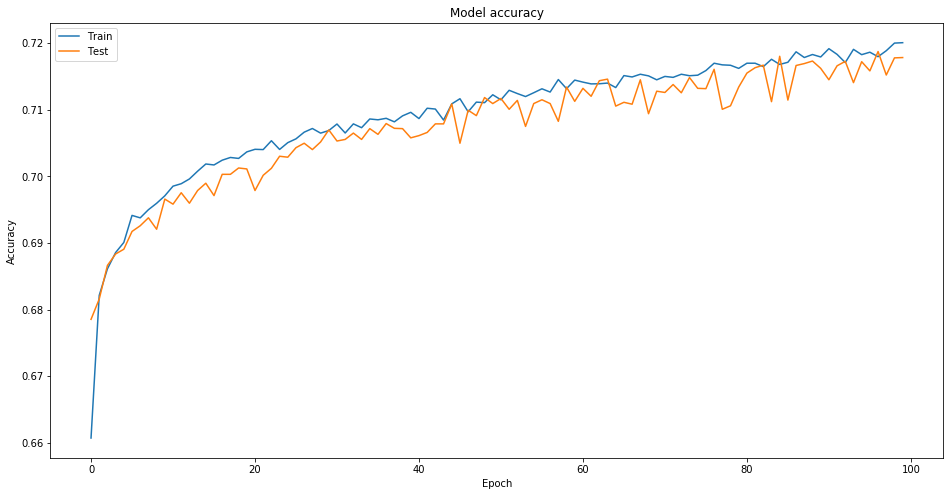

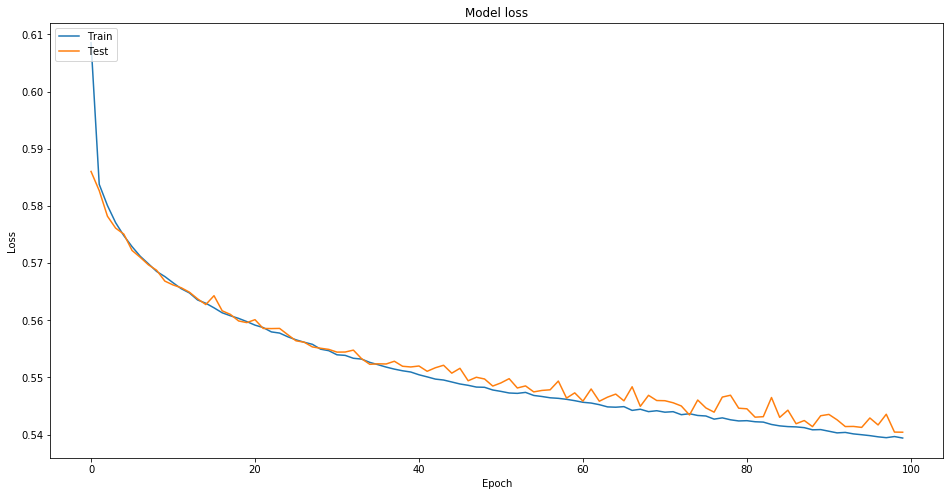

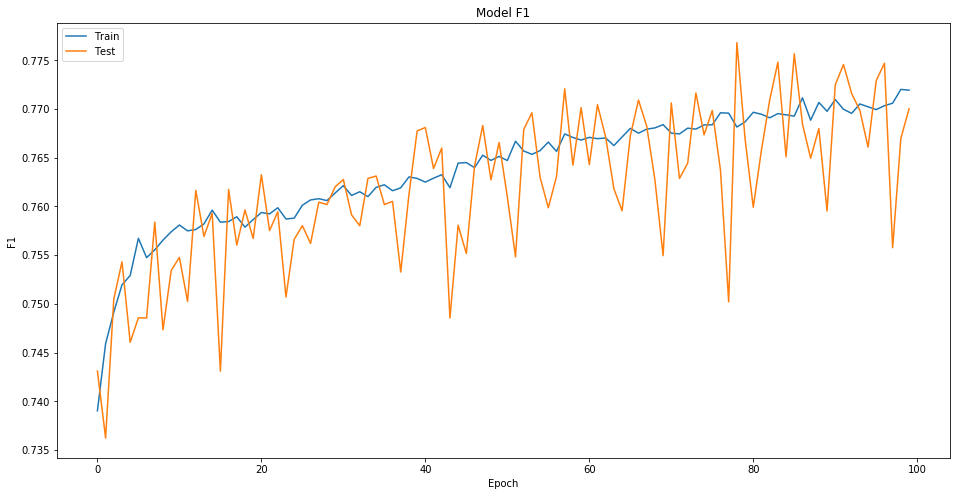

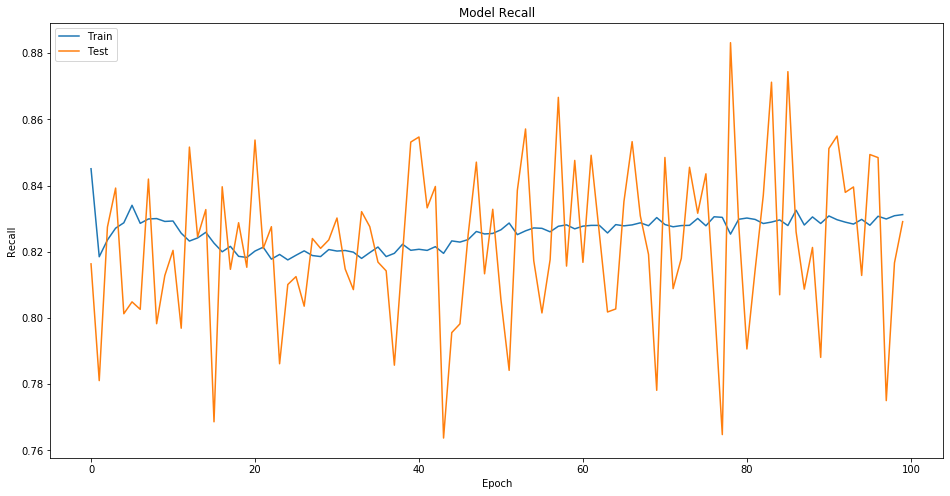

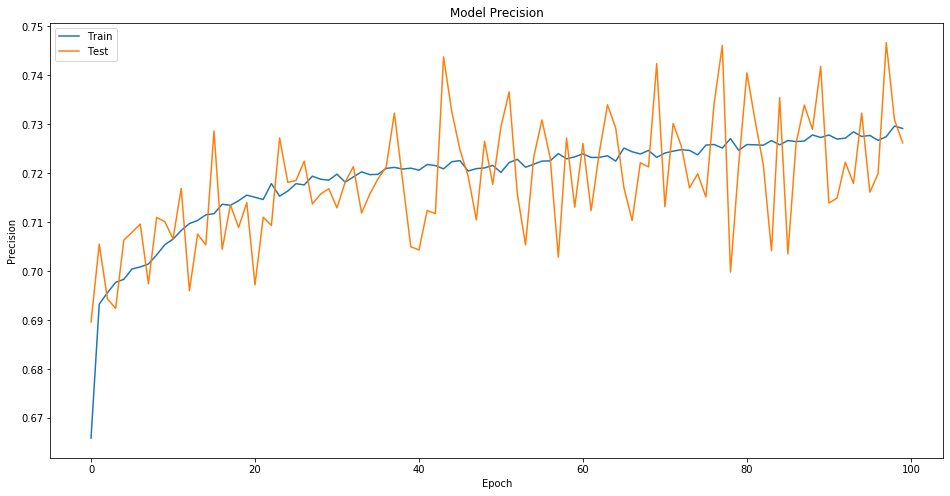

In [99]:
#Plot training & validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
ax2 = plt.plot(history.history['loss'])
ax2= plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plot training & validation F-1
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('Model F1')
plt.ylabel('F1')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plot training & validation recall 
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#Plot training & validation precision 
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
#loss: 0.5179 - accuracy: 0.7380 - f1_m: 0.7853 - precision_m: 0.7447 - recall_m: 0.8422
#data_f = data_train[['goal', 'staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length', 'competitors_qtr', 'competitors_month', 'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design', 'category_fashion', 'category_film & video', 'category_food', 'category_games', 'category_journalism', 'category_music', 'category_photography', 'category_publishing', 'category_technology', 'category_theater', 'funded']]
#loss: 0.5144 - accuracy: 0.7394 - f1_m: 0.7855 - precision_m: 0.7463 - recall_m: 0.8401

#200 epoch: 0.5221889174143474, 0.7361000180244446, 0.7870576977729797, 0.7334079742431641, 0.8584153056144714

Test Data Cleaning and Standardization

In [10]:
#standardize: staff_pick
boolean_v = []
for i in range(len(data_test)):
    boolean = data_test.iloc[i].staff_pick
    if boolean == True:
        boolean_v.append(1)
    elif boolean == False:
        boolean_v.append(0)
data_test['staff_pick'] = boolean_v

In [11]:
#period_lc   #period_dl   #money_pday
launched_at = []
created_at = []
deadline = []
for i in range(len(data_test)):
    launched_at.append(datetime.utcfromtimestamp(data_test.iloc[i].launched_at).strftime('%Y-%m-%d'))
    created_at.append(datetime.utcfromtimestamp(data_test.iloc[i].created_at).strftime('%Y-%m-%d'))
    deadline.append(datetime.utcfromtimestamp(data_test.iloc[i].deadline).strftime('%Y-%m-%d'))

date_format = "%Y-%m-%d"
period_lc = []
period_dl = []
money_pday = []
for i in range(len(data_test)):
    l = launched_at[i]
    l = datetime.strptime(l, date_format)
    c = created_at[i]
    c = datetime.strptime(c, date_format)
    d = deadline[i]
    d = datetime.strptime(d, date_format)
    lc = l - c
    period_lc.append(lc.days)
    dl = d - l
    period_dl.append(dl.days)
    money_pday.append(math.ceil(data_test.iloc[i].goal / dl.days)) 
data_test['period_lc'] = period_lc
data_test['period_dl'] = period_dl
data_test['money_pday'] = money_pday

In [13]:
#standardize: name_length
data_test['name_length'] = data_test['name']
name_length = []
for i in range(len(data_test)):
    if data_test.iloc[i].name_length != data_test.iloc[i].name_length:
        name_length.append(0)
    else:
        name_length.append(len(data_test.iloc[i].name_length)) 
data_test['name_length'] = name_length

In [14]:
#standardize: goal
goal_usd = []
for i in range(len(data_test)):
    value = math.ceil(data_test.iloc[i].fx_rate * data_test.iloc[i].goal)
    goal_usd.append(value)
data_test['goal'] = goal_usd

In [15]:
#standardize: blurb_length
data_test['blurb'].astype(str)
blurb_length = []
for i in range(len(data_test)):
    if data_test.iloc[i].blurb != data_test.iloc[i].blurb:
        blurb_length.append(0)
    else:
        blurb_length.append(len(data_test.iloc[i].blurb))  
data_test['blurb_length'] = blurb_length

In [100]:
data_test['launched_month'] = data_test['launched_at'].apply(get_month)
data_test['launched_week'] = data_test['launched_at'].apply(get_week)
data_test['launched_quarter'] = data_test['launched_at'].apply(get_quarter)
data_test['goal_cat_perc'] =  data_test.groupby(['category'])['goal'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =[1,2,3]))
data_test['duration_cat_perc'] =  data_test.groupby(['category'])['period_dl'].transform(
                     lambda x: pd.qcut(x, [0, .35, .70, 1.0], labels =False, duplicates='drop'))

KeyError: 'Column not found: period_dl'

In [53]:
data_test['competitors_qtr'] = data_test.groupby(['category','launched_year','launched_quarter','goal_cat_perc'])['funded'].transform('count')
data_test['competitors_month'] = data_test.groupby(['category','launched_year','launched_month','goal_cat_perc'])['funded'].transform('count')

KeyError: 'launched_year'

In [180]:
data_test = pd.get_dummies(data_test, columns = ['category'])

Test dataset prediction

In [ ]:
data_eval = data_test[['goal', 'staff_pick', 'blurb_length', 'period_lc', 'period_dl', 'money_pday', 'name_length', 'competitors_qtr', 'competitors_month', 'category_art', 'category_comics', 'category_crafts', 'category_dance', 'category_design', 'category_fashion', 'category_film & video', 'category_food', 'category_games', 'category_journalism', 'category_music', 'category_photography', 'category_publishing', 'category_technology', 'category_theater', 'funded']]

In [ ]:
X_t = data_eval.values
scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler.fit(scaler, X_t)
X_test = scaler.transform(X_t)

In [ ]:
probabilities = model.predict(X_test)
probabilities.to_list()
pred_results = pd.DataFrame(index = data_test.index)
ped_results['your_prediction'] = probabilities

In [ ]:
import csv
label_file = "predictions.tsv"
with open(label_file, 'w') as write_tsv:
    write_tsv.write(ped_results.to_csv(sep='\t', index = True))